# Implementing Portfolio Insurance (CPPI) and Drawdown Constraints

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import edhec_risk_kit as erk

In [2]:
# load industry returns and total market index
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

In [3]:
risky_r = ind_return['2000':][['Steel', 'Fin', 'Beer']]
# fake safe asset
safe_r = pd.DataFrame().reindex_like(risky_r)

In [4]:
# enter fake safe value
safe_r[:] = 0.03/12
start = 1000
floor = 0.8

In [5]:
risky_r.shape

(228, 3)

In [6]:
safe_r.shape

(228, 3)

In [7]:
# timing for loops
def compound1(r):
    return (1+r).prod()-1


def compound2(r):
    return np.expm1(np.log1p(r).sum())

In [8]:
%timeit compound1(risky_r)

1.37 ms ± 46 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
%timeit compound2(risky_r)

395 µs ± 3.48 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## CPPI Algorithm (for every unit of time)
1. Cushion -> asset value - floor value
2. Compute an allocation to safe and risky assets -> m*risk budget
3. Recompute asset value based on returns

In [102]:
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3
account_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)

for step in range(n_steps):
    cushion = (account_value-floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # update account value for timestamp
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    # save to look at history
    account_history.iloc[step] = account_value
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w

In [89]:
risky_wealth = start*(1+risky_r).cumprod()

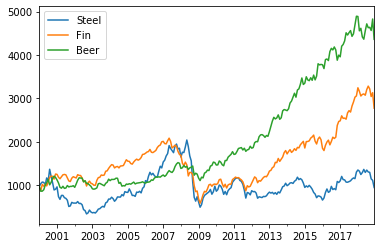

In [90]:
risky_wealth.plot()

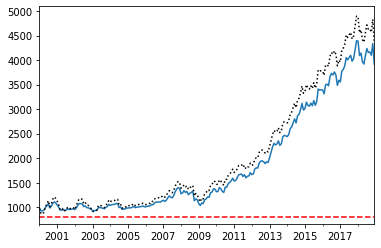

In [95]:
ind = ['Beer', 'Fin', 'Steel']

ax = account_history[ind[0]].plot()
risky_wealth[ind[0]].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

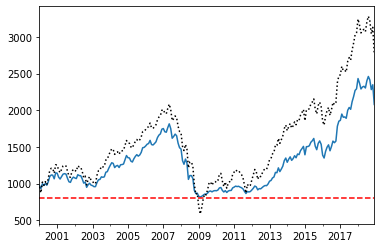

In [96]:
ax = account_history[ind[1]].plot()
risky_wealth[ind[1]].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')

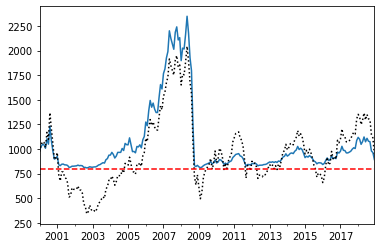

In [97]:
ax = account_history[ind[2]].plot()
risky_wealth[ind[2]].plot(ax=ax, style='k:')
ax.axhline(y=floor_value, color='r', linestyle='--')